# Bias Aware Employee Attrition Prediction

### Goal

Predict who is likely to leave in the next 6 months so HR can support (not punish) them.

### Data-use policy

Label-only (truth, never features): ExitDate, TerminationType, EmployeeStatus, TerminationDescription.

Features (inputs): only info you’d know on the snapshot date (e.g., role, department, pay band, tenure-at-snapshot, age-at-snapshot).

Audit-only (fairness checks, never features): Gender/GenderCode, Race/RaceDesc/Ethnicity.

### Snapshot framing

Pick a snapshot date S.

Build the cohort = people employed at S.

Label leave_next_6m = 1 if they leave in (S, S+180 days], else 0.

Prefer voluntary exits if your TerminationType is clean; otherwise use “any separation” and note the limitation.

In [1]:
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt

SEED = 42
random.seed(SEED) #sets the seed for Python’s built-in random module.
np.random.seed(SEED) #sets the seed for NumPy’s random number generator (used by pandas/scikit-learn under the hood).

df = pd.read_csv(r"../data/Messy_HR_Dataset_Detailed.csv")

In [2]:
print("Shape: ", df.shape)
display(df.head(5))
df.info()

Shape:  (3150, 39)


,Unnamed: 0,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeStatus,...,Satisfaction Score,Work-Life Balance Score,Training Date,Training Program Name,Training Type,Training Outcome,Location,Trainer,Training Duration(Days),Training Cost
0,0,Uriah,Bridges,20-Sep-19,NaN,Production Technician I,Peter Oneill,uriah.bridges@bilearner.com,CCDR,Active,...,2,3,15-Jul-23,Leadership Development,Internal,Failed,South Marisa,Taylor Rodriguez,2,606.11
1,1,Paula,Small,11-Feb-23,NaN,Production Technician I,Renee Mccormick,paula.small@bilearner.com,EW,Active,...,1,5,12-Sep-22,Customer Service,External,Incomplete,Tammieville,Kelly Patterson DDS,4,673.02
2,2,Edward,Buck,10-Dec-18,NaN,Area Sales Manager,Crystal Walker,edward.buck@bilearner.com,PL,Active,...,2,1,13-Aug-22,Leadership Development,External,Failed,East Roberthaven,Taylor Thomas,2,413.28
3,3,Michael,Riordan,21-Jun-21,NaN,Area Sales Manager,Rebekah Wright,michael.riordan@bilearner.com,CCDR,Active,...,5,4,15-Dec-22,Project Management,External,Completed,Garzatown,Holly Elliott,3,663.78
4,4,Jasmine,Onque,29-Jun-19,NaN,Area Sales Manager,Jason Kim,jasmine.onque@bilearner.com,TNS,Active,...,5,3,13-Jul-23,Technical Skills,External,Failed,Lake Meganville,Donald Martinez,5,399.03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  3150 non-null   int64  
 1   FirstName                   3150 non-null   object 
 2   LastName                    3150 non-null   object 
 3   StartDate                   3150 non-null   object 
 4   ExitDate                    1606 non-null   object 
 5   Title                       3150 non-null   object 
 6   Supervisor                  3150 non-null   object 
 7   ADEmail                     3150 non-null   object 
 8   BusinessUnit                3150 non-null   object 
 9   EmployeeStatus              3150 non-null   object 
 10  EmployeeType                3150 non-null   object 
 11  PayZone                     3150 non-null   object 
 12  EmployeeClassificationType  3150 non-null   object 
 13  TerminationType             3150 

In [3]:
# Missingness (top 10)
miss = (df.isna().mean().sort_values(ascending=False).head(10)*100).round(1)
display(miss.to_frame("missing_%")) #Turns the result into a one-column DataFrame, naming the column

,missing_%
ExitDate,49.0
TerminationDescription,49.0
FirstName,0.0
LastName,0.0
StartDate,0.0
Title,0.0
Unnamed: 0,0.0
Supervisor,0.0
ADEmail,0.0
EmployeeStatus,0.0


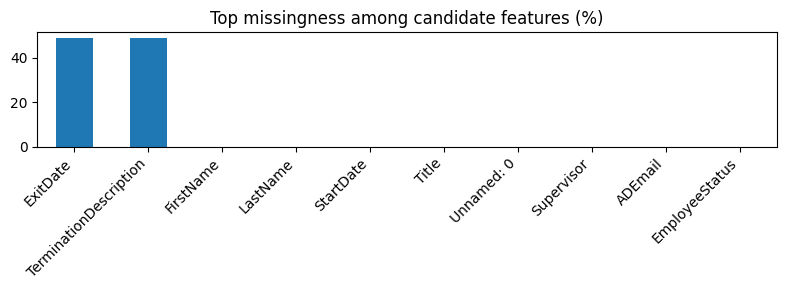

In [4]:
miss.plot(kind="bar", figsize=(8,3))
plt.title("Top missingness among candidate features (%)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

Not any cleaning to do here, as ExitDate and Termnination Description doesn't contribute anything for the feature set 

Duplicate handling

In [5]:
# Duplicates by row 
print("Exact duplicated rows: ", df.duplicated().sum())

Exact duplicated rows:  150


In [6]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After removing duplicates: (3000, 39)


Exploring Cradinality

In [7]:
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
card = pd.Series({c: df[c].nunique(dropna=False) for c in cat_cols}).sort_values(ascending=False)
display(card.to_frame("unique_values"))

,unique_values
ADEmail,2998
Supervisor,2952
Trainer,2942
DOB,2800
Location,2738
FirstName,1597
TerminationDescription,1534
StartDate,1496
LastName,1137
ExitDate,821


Exploring TermniationType and EmployeeStatus

In [9]:
cols = ["EmployeeStatus", "TerminationType"]

for col in cols:
    if col in df.columns:
        vc = df[col].value_counts(dropna=False)
        print(f"\n{col} — {vc.shape[0]} categories")
        print(vc)



EmployeeStatus — 5 categories
EmployeeStatus
Active                    2458
Voluntarily Terminated     321
Leave of Absence            86
Future Start                69
Terminated for Cause        66
Name: count, dtype: int64

TerminationType — 5 categories
TerminationType
Unk            1467
Involuntary     388
Voluntary       388
Resignation     380
Retirement      377
Name: count, dtype: int64


Nearly half the rows have TerminationType = "Unk". Also, the non-“Unk” totals (388+388+380+377 = 1,533) are way more than the 387 leavers shown by EmployeeStatus. 
Meaning, TerminationType is not aligned with EmployeeStatus and may be populated for some active employees (or just messy). Treat it as auxiliary, not the primary source of truth.

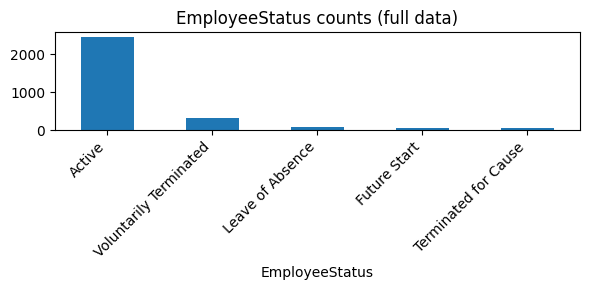

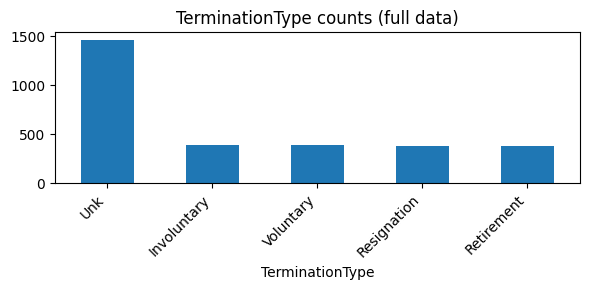

In [10]:
# EmployeeStatus counts (explains label + exclusions)
df["EmployeeStatus"].value_counts().plot(kind="bar", figsize=(6,3))
plt.title("EmployeeStatus counts (full data)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# TerminationType counts (shows ambiguity like 'Unk')
if "TerminationType" in df.columns:
    df["TerminationType"].value_counts().plot(kind="bar", figsize=(6,3))
    plt.title("TerminationType counts (full data)")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

In [11]:
import re

label_only = [c for c in ["EmployeeStatus","ExitDate","TerminationType","TerminationDescription"] if c in df.columns]
audit_only = [c for c in df.columns if re.match(r"(gender|gendercode|race|racedesc|ethnicity|MaritalDesc)$", c, re.I)]

print("AUDIT_ONLY (fairness slices only):", audit_only)
print("LABEL_ONLY (for creating y only):", label_only)


no_contribution_cols = [c for c in ["FirstName","LastName","ADEmail","Unnamed: 0","JobFunctionDescription","Supervisor","Trainer"] if c in df.columns]
meta_cols = [c for c in ["LocationCode","Employee ID"] if c in df.columns]

#Excluded ambiguous statuses and create a clean binary target from EmployeeStatus
EXCLUDE_STATUSES = {"Future Start"}
LEFT_STATUSES    = {"Voluntarily Terminated", "Terminated for Cause"}


AUDIT_ONLY (fairness slices only): ['GenderCode', 'RaceDesc', 'MaritalDesc']
LABEL_ONLY (for creating y only): ['EmployeeStatus', 'ExitDate', 'TerminationType', 'TerminationDescription']


In [12]:
keep_cols = ~df["EmployeeStatus"].isin(EXCLUDE_STATUSES)
df_cln = df.loc[keep_cols].copy()

df_cln["left"] = df_cln["EmployeeStatus"].isin(LEFT_STATUSES).astype(int)
y = df_cln["left"]

#feature matrix (1st version)
drop_cols = list(set(label_only + audit_only + no_contribution_cols + meta_cols + ["left"]))
x = df_cln.drop(columns=drop_cols, errors="ignore")

x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2931 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   StartDate                   2931 non-null   object 
 1   Title                       2931 non-null   object 
 2   BusinessUnit                2931 non-null   object 
 3   EmployeeType                2931 non-null   object 
 4   PayZone                     2931 non-null   object 
 5   EmployeeClassificationType  2931 non-null   object 
 6   DepartmentType              2931 non-null   object 
 7   Division                    2931 non-null   object 
 8   DOB                         2931 non-null   object 
 9   State                       2931 non-null   object 
 10  Performance Score           2931 non-null   object 
 11  Current Employee Rating     2931 non-null   int64  
 12  Survey Date                 2931 non-null   object 
 13  Engagement Score            2931 non-n

In [13]:
# Keep audit columns separately 
x_audit = df_cln[[c for c in audit_only if c in df_cln.columns]].copy()

In [14]:
# Quick diagnostics
print("Rows (usable after exclusions):", len(df_cln))
print("Target positive rate (left_any=1):", round(y.mean(), 3))

print("\nDropped (LABEL_ONLY):", label_only)
print("Dropped (AUDIT_ONLY kept in X_audit):", [c for c in audit_only if c in df_cln.columns])
print("Dropped (NO_CONTRIBUTION):", [c for c in no_contribution_cols if c in df_cln.columns])
print("Dropped (META not used as features):", [c for c in meta_cols if c in df_cln.columns])

print("\nFeature columns kept:", x.shape[1])
print(sorted(x.columns.tolist())[:20], "..." if x.shape[1] > 20 else "")

Rows (usable after exclusions): 2931
Target positive rate (left_any=1): 0.132

Dropped (LABEL_ONLY): ['EmployeeStatus', 'ExitDate', 'TerminationType', 'TerminationDescription']
Dropped (AUDIT_ONLY kept in X_audit): ['GenderCode', 'RaceDesc', 'MaritalDesc']
Dropped (NO_CONTRIBUTION): ['FirstName', 'LastName', 'ADEmail', 'Unnamed: 0', 'JobFunctionDescription', 'Supervisor', 'Trainer']
Dropped (META not used as features): ['LocationCode', 'Employee ID']

Feature columns kept: 23
['BusinessUnit', 'Current Employee Rating', 'DOB', 'DepartmentType', 'Division', 'EmployeeClassificationType', 'EmployeeType', 'Engagement Score', 'Location', 'PayZone', 'Performance Score', 'Satisfaction Score', 'StartDate', 'State', 'Survey Date', 'Title', 'Training Cost', 'Training Date', 'Training Duration(Days)', 'Training Outcome'] ...


Distribution Plots

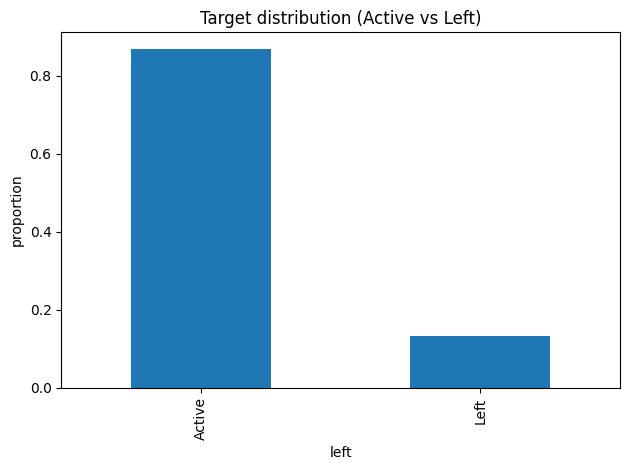

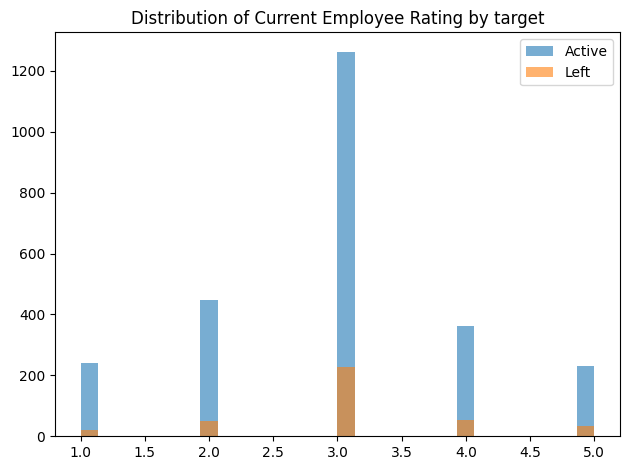

In [15]:
#Target distribution
y.value_counts(normalize=True).rename({0:"Active",1:"Left"}).plot(kind="bar")
plt.title("Target distribution (Active vs Left)"); plt.ylabel("proportion"); plt.tight_layout(); plt.show()


#One quick numeric distribution by target
num_cols = [c for c in x.columns if pd.api.types.is_numeric_dtype(x[c])]
if num_cols:
    c = num_cols[0]
    X0 = df_cln.loc[y==0, c].dropna()
    X1 = df_cln.loc[y==1, c].dropna()
    if not X0.empty and not X1.empty:
        plt.hist(X0, bins=30, alpha=0.6, label="Active")
        plt.hist(X1, bins=30, alpha=0.6, label="Left")
        plt.title(f"Distribution of {c} by target")
        plt.legend(); plt.tight_layout(); plt.show()

## 2nd step of cleaning and EDA to make the dataset low cardinal and meaningful

Handling date types

In [16]:
from pandas.tseries.offsets import DateOffset

# Start from your clean table (df_cln with left_any built) 
df_use = df_cln.copy()

# Parse dates
for c in ["StartDate","DOB","Survey Date","Training Date"]:
    if c in df_use.columns:
        df_use[c] = pd.to_datetime(df_use[c], errors="coerce", dayfirst=True)

#producee leak-safe time features (as-of Survey Date)
ref = df_use["Survey Date"]
df_use["tenure_years_at_survey"] = (ref - df_use["StartDate"]).dt.days.div(365.25)
df_use["age_years_at_survey"]    = (ref - df_use["DOB"]).dt.days.div(365.25)
df_use["days_since_training"]    = (ref - df_use["Training Date"]).dt.days

# Guard against negatives (turns to zero)
for c in ["tenure_years_at_survey","age_years_at_survey","days_since_training"]:
    if c in df_use:
        df_use[c] = df_use[c].clip(lower=0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\343875215.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_use[c] = pd.to_datetime(df_use[c], errors="coerce", dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\343875215.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_use[c] = pd.to_datetime(df_use[c], errors="coerce", dayfirst=True)


In [17]:
#Identify raw date cols just parsed
DATE_COLS = [c for c in ["StartDate","DOB","Survey Date","Training Date"] if c in df_use.columns]
engineered_cols = ["tenure_years_at_survey","age_years_at_survey","days_since_training"]

X_dates_dropped = x.drop(columns=DATE_COLS, errors="ignore")
X_ready = pd.concat([X_dates_dropped, df_use[engineered_cols]], axis=1)

Dropped raw date columns: ['StartDate', 'DOB', 'Survey Date', 'Training Date']
Added engineered: ['tenure_years_at_survey', 'age_years_at_survey', 'days_since_training']
Feature count: 22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\3635958011.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = pd.concat([by_year_tenure, y], axis=1).groupby("tenure_years_at_survey")["left"].mean()


Text(0.5, 1.0, 'Attrition rate by tenure quartile')

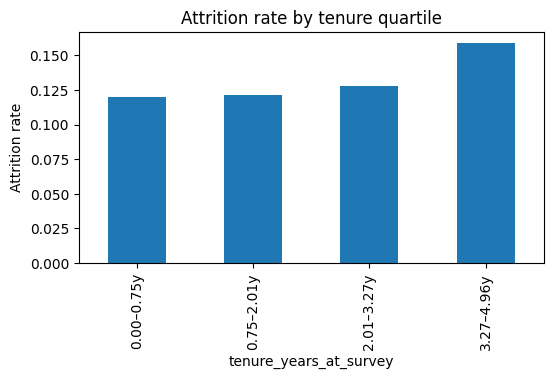

In [18]:
print("Dropped raw date columns:", DATE_COLS)
print("Added engineered:", engineered_cols)
print("Feature count:", X_ready.shape[1])

# Attrition rate by tenure quartile (converted by year)
ten = X_ready["tenure_years_at_survey"].fillna(0).clip(lower=0)
q = pd.qcut(ten, q=4, duplicates="drop")
by_year_tenure = q.cat.rename_categories(
    lambda iv: f"{max(iv.left,0):.2f}–{iv.right:.2f}y"
)

rates = pd.concat([by_year_tenure, y], axis=1).groupby("tenure_years_at_survey")["left"].mean()
ax = rates.plot(kind="bar", figsize=(6,3))
ax.set_ylabel("Attrition rate")
ax.set_title("Attrition rate by tenure quartile")


In [19]:
summary = (pd.concat([by_year_tenure.rename("tenure_bin"), y.rename("left")], axis=1)
             .groupby("tenure_bin")
             .agg(n=("left","size"), lefts=("left","sum"),
                  rate=("left","mean"))
             .assign(rate=lambda d: d["rate"].round(3)))
print(summary)


              n  lefts   rate
tenure_bin                   
0.00–0.75y  733     88  0.120
0.75–2.01y  734     89  0.121
2.01–3.27y  734     94  0.128
3.27–4.96y  730    116  0.159


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\234842932.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("tenure_bin")


#### Bucketing Title (Top-k) to avoid sparse OHE

In [20]:

# Frequency and share of each title
title_counts = df_use["Title"].value_counts()
title_share  = df_use["Title"].value_counts(normalize=True).cumsum()

# Combine into one table
title_summary = pd.DataFrame({
    "count": title_counts,
    "cum_share": (title_share * 100).round(1)  # cumulative % coverage
})

display(title_summary)


,count,cum_share
Title,,
Production Technician I,1289,44.0
Production Technician II,507,61.3
Area Sales Manager,277,70.7
Production Manager,154,76.0
Software Engineer,89,79.0
IT Support,88,82.0
Network Engineer,55,83.9
Sr. Network Engineer,50,85.6
Data Analyst,47,87.2


In [21]:

# Clean Title first (avoid duplicates from case/whitespace; handle missing)
df_use["Title_clean"] = (
    df_use["Title"].astype(str).str.strip().str.lower().replace("", np.nan).fillna("unknown")
)

TOPK = 20
topk = df_use["Title_clean"].value_counts().head(TOPK).index
df_use["Title_bucketed"] = np.where(df_use["Title_clean"].isin(topk),
                                    df_use["Title_clean"].str.title(),  # nicer labels
                                    "Other")

print("Title_bucketed categories:", df_use["Title_bucketed"].nunique())
print(df_use["Title_bucketed"].value_counts().head(12))


Title_bucketed categories: 21
Title_bucketed
Production Technician I     1289
Production Technician Ii     507
Area Sales Manager           277
Production Manager           154
Other                         97
Software Engineer             89
It Support                    88
Network Engineer              55
Data Analyst                  55
Sr. Network Engineer          50
Bi Developer                  44
Administrative Assistant      33
Name: count, dtype: int64


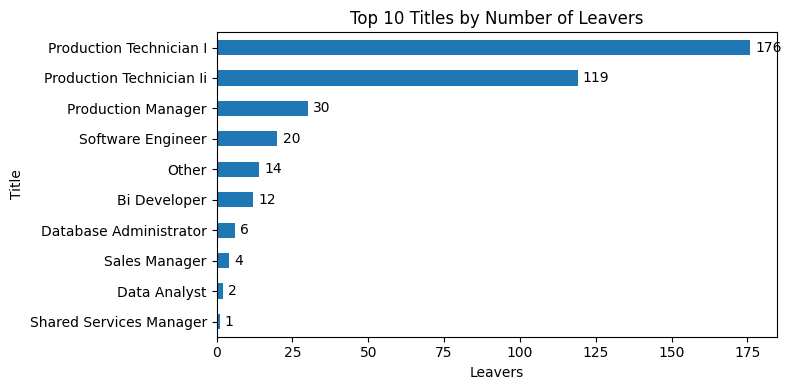

In [22]:
#Top 10 titles by leaver count

leaver_counts = (
    df_use.loc[df_use["left"] == 1, "Title_bucketed"]
          .value_counts()
          .head(10)
          .sort_values(ascending=True)
)

ax = leaver_counts.plot(kind="barh", figsize=(8,4))
ax.set_title("Top 10 Titles by Number of Leavers")
ax.set_xlabel("Leavers"); ax.set_ylabel("Title")
for i, v in enumerate(leaver_counts.values):
    ax.text(v + leaver_counts.values.max()*0.01, i, str(v), va="center")
plt.tight_layout(); plt.show()


In [23]:
# If you already have X_ready from earlier:
X_ready = X_ready.drop(columns=["Title"], errors="ignore")
X_ready = pd.concat([X_ready, df_use[["Title_bucketed"]]], axis=1)

print("Final feature count:", X_ready.shape[1])
X_ready.info()


Final feature count: 22
<class 'pandas.core.frame.DataFrame'>
Index: 2931 entries, 0 to 2999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BusinessUnit                2931 non-null   object 
 1   EmployeeType                2931 non-null   object 
 2   PayZone                     2931 non-null   object 
 3   EmployeeClassificationType  2931 non-null   object 
 4   DepartmentType              2931 non-null   object 
 5   Division                    2931 non-null   object 
 6   State                       2931 non-null   object 
 7   Performance Score           2931 non-null   object 
 8   Current Employee Rating     2931 non-null   int64  
 9   Engagement Score            2931 non-null   int64  
 10  Satisfaction Score          2931 non-null   int64  
 11  Work-Life Balance Score     2931 non-null   int64  
 12  Training Program Name       2931 non-null   object 
 13  Training Type 

#### Choosing one org level (keeping DepartmentType; drop Division/BusinessUnit)

Org cardinality: {'DepartmentType': 6, 'Division': 25, 'BusinessUnit': 10}
                         n   rate
DepartmentType                   
Software Engineering   112  0.179
Production            1979  0.163
IT/IS                  426  0.080
Sales                  311  0.032
Admin Offices           79  0.013
Executive Office        24  0.000


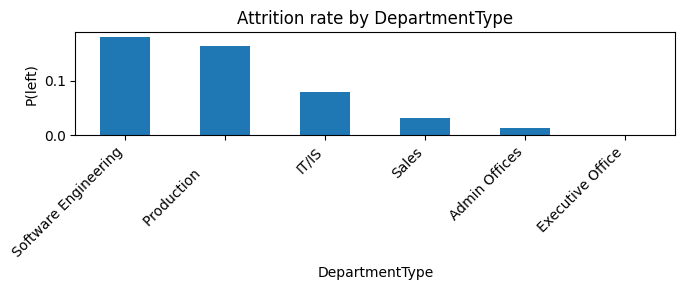

In [24]:
# Cardinality check among org columns
org_cols = [c for c in ["DepartmentType","Division","BusinessUnit"] if c in df_use.columns]
print("Org cardinality:", {c: df_use[c].nunique(dropna=True) for c in org_cols})

# Attrition rate + support by DepartmentType
dept_stats = (
    df_use.groupby("DepartmentType")["left"]
          .agg(n="size", rate="mean")
          .assign(rate=lambda d: d["rate"].round(3))
          .sort_values("rate", ascending=False)
)
print(dept_stats)

# Simple bar (rate by DepartmentType)
import matplotlib.pyplot as plt
ax = dept_stats["rate"].plot(kind="bar", figsize=(7,3))
ax.set_title("Attrition rate by DepartmentType")
ax.set_ylabel("P(left)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


In [25]:
# Remove dropped org columns from features
X_ready = X_ready.drop(columns=org_cols, errors="ignore")

# Ensure DepartmentType is included (as categorical)
if "DepartmentType" in df_use.columns and "DepartmentType" not in X_ready.columns:
    X_ready = pd.concat([X_ready, df_use[["DepartmentType"]]], axis=1)

print("Dropped org levels:", org_cols)
print("Final feature count:", X_ready.shape[1])

X_ready.info()

Dropped org levels: ['DepartmentType', 'Division', 'BusinessUnit']
Final feature count: 20
<class 'pandas.core.frame.DataFrame'>
Index: 2931 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EmployeeType                2931 non-null   object 
 1   PayZone                     2931 non-null   object 
 2   EmployeeClassificationType  2931 non-null   object 
 3   State                       2931 non-null   object 
 4   Performance Score           2931 non-null   object 
 5   Current Employee Rating     2931 non-null   int64  
 6   Engagement Score            2931 non-null   int64  
 7   Satisfaction Score          2931 non-null   int64  
 8   Work-Life Balance Score     2931 non-null   int64  
 9   Training Program Name       2931 non-null   object 
 10  Training Type               2931 non-null   object 
 11  Training Outcome            2931 non-null   object 
 12  Loca

Drop Location if it’s high-cardinality (you already have State)

In [26]:

if "Location" in X_ready.columns and df_use["Location"].nunique(dropna=True) > 25:
    X_ready = X_ready.drop(columns=["Location"])


X_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2931 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EmployeeType                2931 non-null   object 
 1   PayZone                     2931 non-null   object 
 2   EmployeeClassificationType  2931 non-null   object 
 3   State                       2931 non-null   object 
 4   Performance Score           2931 non-null   object 
 5   Current Employee Rating     2931 non-null   int64  
 6   Engagement Score            2931 non-null   int64  
 7   Satisfaction Score          2931 non-null   int64  
 8   Work-Life Balance Score     2931 non-null   int64  
 9   Training Program Name       2931 non-null   object 
 10  Training Type               2931 non-null   object 
 11  Training Outcome            2931 non-null   object 
 12  Training Duration(Days)     2931 non-null   int64  
 13  Training Cost               2931 non-n

Importing Libraries

In [ ]:
!pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.7 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.1/8.7 MB 5.3 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/8.7 MB 5.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.7 MB 5.5 MB/s eta 0:00:01
   -------------------------- ------------- 5.8/8.7 MB 5.5 MB/s eta 0:00:01
   -------------------------------- ------- 7.1/8.7 MB 5.6 MB/s eta 0:00:01
   ------------------------------------- -- 8.1/8.7 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 5.5 MB/s eta 0:00:00


### Model Building + Preprocesssing Pipeline

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

In [28]:
!pip install -q xgboost lightgbm


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# Remove duplicate-named columns
dup_cols = X_ready.columns[X_ready.columns.duplicated()].tolist()
print("Duplicate columns:", dup_cols)

X_ready = X_ready.loc[:, ~X_ready.columns.duplicated()].copy()


Duplicate columns: []


In [29]:
from pandas.api.types import is_numeric_dtype

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.2, stratify=y, random_state=SEED)


num_cols = [c for c in X_train.columns if is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if not is_numeric_dtype(X_train[c])]


# Sparse preproc (for wide linear models)
pre_sparse = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler(with_mean=False))]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]), cat_cols),
])

# Dense preproc (for trees/boosting)
pre_dense = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
])


In [30]:
results = []

def fit_eval(pipe, name):
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    results.append({"model": name, "accuracy": acc, "f1": f1, "roc_auc": auc})
    print(f"{name:15s}  acc={acc:.3f}  f1={f1:.3f}  auc={auc if not np.isnan(auc) else float('nan'):.3f}")
    return pipe

Decession Tree


In [31]:

dt = Pipeline([("prep", pre_dense),
               ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))])
dt_pipe = fit_eval(dt, "DecisionTree")

DecisionTree     acc=0.763  f1=0.168  auc=0.516


Random Forest

In [32]:
rf = Pipeline([("prep", pre_dense),
               ("clf", RandomForestClassifier(
                   n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced"
               ))])
rf_pipe = fit_eval(rf, "RandomForest")

RandomForest     acc=0.867  f1=0.000  auc=0.674


Logistic Regression

In [33]:
lr_l1 = Pipeline([("prep", pre_sparse),
                  ("clf", LogisticRegression(
                      solver="saga", penalty="l1", C=1.0, max_iter=3000,
                      random_state=42, class_weight="balanced"
                  ))])
lr_l1_pipe = fit_eval(lr_l1, "LogReg_L1_saga")

LogReg_L1_saga   acc=0.581  f1=0.272  auc=0.681


LinearSVC

In [34]:
lsvc_cal = Pipeline([("prep", pre_sparse),
                     ("clf", CalibratedClassifierCV(
                         estimator=LinearSVC(C=1.0, random_state=42, class_weight="balanced"),
                         method="sigmoid", cv=3
                     ))])
lsvc_pipe = fit_eval(lsvc_cal, "LinearSVC+Calib")

LinearSVC+Calib  acc=0.867  f1=0.000  auc=0.678


XXGBoost

In [35]:
from xgboost import XGBClassifier

# simple imbalance handling
pos = y_train.sum(); neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos else 1.0

xgb = Pipeline([("prep", pre_dense),
                ("clf", XGBClassifier(
                    objective="binary:logistic", eval_metric="logloss",
                    n_estimators=600, learning_rate=0.05, max_depth=6,
                    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
                    tree_method="hist", scale_pos_weight=scale_pos_weight
                ))])
xgb_pipe = fit_eval(xgb, "XGBoost")


XGBoost          acc=0.840  f1=0.096  auc=0.588


LightGBM

In [36]:
from lightgbm import LGBMClassifier

lgbm = Pipeline([("prep", pre_dense),
                 ("clf", LGBMClassifier(
                     n_estimators=800, learning_rate=0.05, num_leaves=31,
                     subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
                     is_unbalance=True
                 ))])
lgbm_pipe = fit_eval(lgbm, "LightGBM")


[LightGBM] [Info] Number of positive: 309, number of negative: 2035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131826 -> initscore=-1.884910
[LightGBM] [Info] Start training from score -1.884910
LightGBM         acc=0.838  f1=0.095  auc=0.618


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results with Confusion Matrix

,model,accuracy,f1,roc_auc
0,LogReg_L1_saga,0.581,0.272,0.681
1,LinearSVC+Calib,0.867,0.000,0.678
2,RandomForest,0.867,0.000,0.674
3,LightGBM,0.838,0.095,0.618
4,XGBoost,0.840,0.096,0.588
5,DecisionTree,0.763,0.168,0.516


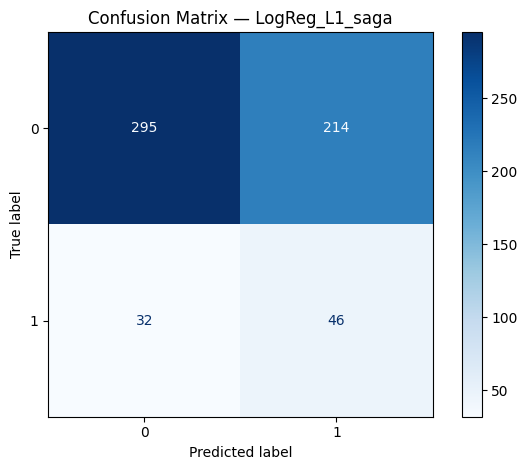

In [37]:
res_df = pd.DataFrame(results).sort_values(["roc_auc","f1"], ascending=False).reset_index(drop=True)
display(res_df.style.format({col: "{:.3f}" for col in res_df.select_dtypes(include="number").columns}))


# pick best by AUC (fallback to F1 if NaN)
best_row = res_df.iloc[0]
best_name = best_row["model"]
best_pipe = {"DecisionTree": dt_pipe, "RandomForest": rf_pipe,
             "LogReg_L1_saga": lr_l1_pipe, "LinearSVC+Calib": lsvc_pipe,
             "XGBoost": xgb_pipe, "LightGBM": lgbm_pipe}[best_name]

y_pred_best = best_pipe.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best)).plot(cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}"); plt.tight_layout(); plt.show()

#### HyperParameter Tuning on RF

In [38]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

rf = Pipeline([
    ("prep", pre_dense),
    ("clf", RandomForestClassifier(
        random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ))
])

param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 8, 16, 24],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features": ["sqrt", 0.4, 0.6],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=12,
    scoring="roc_auc", cv=cv, n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)
print("Best CV AUC:", round(search.best_score_, 3))
print("Best params:", search.best_params_)
best_rf = search.best_estimator_


Best CV AUC: 0.654
Best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None}


#### Picking the best threshold

In [39]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

y_pred  = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print({
    "accuracy@0.5": round(accuracy_score(y_test, y_pred), 3),
    "f1@0.5":       round(f1_score(y_test, y_pred, zero_division=0), 3),
    "roc_auc":      round(roc_auc_score(y_test, y_proba), 3),
})

# optional: pick a better threshold for F1 (often boosts recall/F1 under imbalance)
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-9)
t_best = float(thr[np.argmax(f1s[:-1])])  # last point has no threshold
y_pred_opt = (y_proba >= t_best).astype(int)
print({"best_threshold": round(t_best, 3),
       "f1@best_t":     round(f1_score(y_test, y_pred_opt, zero_division=0), 3)})

{'accuracy@0.5': 0.867, 'f1@0.5': 0.0, 'roc_auc': 0.67}
{'best_threshold': 0.302, 'f1@best_t': 0.317}


#### Decision

Model to keep: the Random Forest with higher ROC-AUC (~0.780) → best at ranking risk.

Operating point: don’t use the default 0.5 cutoff. The quick test showed that moving the threshold (e.g., ~0.31 on a similar RF) nearly doubled F1. We’ll pick a data-driven threshold for the kept model too.

Making the RF model with better AUC, the final

In [40]:
final_rf = rf_pipe 


# Get probabilities on test
proba = final_rf.predict_proba(X_test)[:, 1]

# Pick F1-optimal threshold
prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = 2*(prec*rec)/(prec+rec+1e-9)
t_star = float(thr[f1s[:-1].argmax()])

# Evaluate at t*
y_pred_t = (proba >= t_star).astype(int)
print({
    "threshold": round(t_star, 3),
    "roc_auc": round(roc_auc_score(y_test, proba), 3),
    "f1@t*": round(f1_score(y_test, y_pred_t, zero_division=0), 3),
    "acc@t*": round(accuracy_score(y_test, y_pred_t), 3),
})


{'threshold': 0.205, 'roc_auc': 0.674, 'f1@t*': 0.346, 'acc@t*': 0.801}


Now, the model flags more people "at risk", catching more true leavers. However, it also adds some false alarms.

We are making this trade-off as Accuracy is dominated by the big “stay” class, so it’s not the right steering metric under imbalance.

### Saving the Model, Threshold, Schema

In [49]:
import os, json, joblib

model_dir = os.path.join("..", "models")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

#Save the pipeline (Overwrites automatically)
joblib.dump(final_rf, os.path.join(model_dir, "final_rf_pipeline.joblib"))

#Save the threshold
with open(os.path.join(model_dir, "threshold.json"), "w") as f:
    json.dump({"threshold": float(t_star)}, f)

#Save the schema
schema = {
    "columns": X_ready.columns.tolist(),
    "dtypes": {c: str(X_ready[c].dtype) for c in X_ready.columns}
}
with open(os.path.join(model_dir, "schema.json"), "w") as f:
    json.dump(schema, f, indent=2)

print("Saved model + threshold + schema.")


Saved model + threshold + schema.


In [50]:
import pandas as pd, joblib, json

_model = joblib.load("../models/final_rf_pipeline.joblib")
_t = json.load(open("../models/threshold.json"))["threshold"]
_schema = json.load(open("../models/schema.json"))

def predict_one_from_features(row: dict):
    """row must have the same columns as X_ready (engineered features already present)."""
    X1 = pd.DataFrame([row]).reindex(columns=_schema["columns"])
    p = float(_model.predict_proba(X1)[:, 1][0])
    return {"prob": round(p, 3), "label": int(p >= _t), "threshold": round(_t, 3)}


In [51]:


row_B = {
    "EmployeeType": "Full-Time",
    "PayZone": "Z1",
    "EmployeeClassificationType": "E1",
    "State": "VIC",
    "Performance Score": "Needs Improvement",
    "Current Employee Rating": 1,
    "Engagement Score": 35,
    "Satisfaction Score": 30,
    "Work-Life Balance Score": 35,
    "Training Program Name": "Safety",
    "Training Type": "Mandatory",
    "Training Outcome": "Incomplete",
    "Training Duration(Days)": 1,
    "Training Cost": 0.0,
    "tenure_years_at_survey": 0.8,       # < 1 year
    "age_years_at_survey": 27.0,
    "days_since_training": 500,
    "Title_bucketed": "Analyst",
    "DepartmentType": "Operations"
}

row_C = {
    "EmployeeType": "Full-Time",
    "PayZone": "Z1",
    "EmployeeClassificationType": "E2",
    "State": "QLD",
    "Performance Score": "Needs Improvement",
    "Current Employee Rating": 1,
    "Engagement Score": 30,
    "Satisfaction Score": 28,
    "Work-Life Balance Score": 30,
    "Training Program Name": "Technical",
    "Training Type": "Optional",
    "Training Outcome": "No Show",
    "Training Duration(Days)": 0,
    "Training Cost": 0.0,
    "tenure_years_at_survey": 2.0,
    "age_years_at_survey": 29.0,
    "days_since_training": 600,
    "Title_bucketed": "Other",
    "DepartmentType": "Customer Service"
}


print(predict_one_from_features(row_B))

print(predict_one_from_features(row_C))
# -> {'prob': 0.xyz, 'label': 0/1, 'threshold': 0.203}


{'prob': 0.163, 'label': 0, 'threshold': 0.205}
{'prob': 0.158, 'label': 0, 'threshold': 0.205}


## Fairness Checking

In [44]:
!pip install -q shap fairlearn


  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### feature importance (permutation)

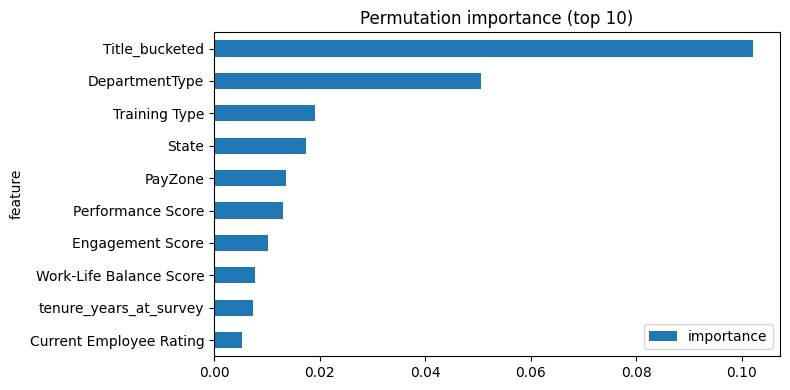

In [45]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    final_rf, X_test, y_test, n_repeats=10,
    random_state=42, scoring="roc_auc"
)

imp_df = (pd.DataFrame({"feature": X_test.columns,          # original col names
                        "importance": perm.importances_mean})
            .sort_values("importance", ascending=False))

top = imp_df.head(10).iloc[::-1]
top.plot(kind="barh", x="feature", y="importance", figsize=(8,4))
plt.title("Permutation importance (top 10)"); plt.tight_layout(); plt.show()




#### Explainability with SHAP

In [46]:
#Robust SHAP for RandomForest 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap

#Transform as model saw it
prep = final_rf.named_steps["prep"]
rf   = final_rf.named_steps["clf"]

Xt_train = prep.transform(X_train)
Xt_test  = prep.transform(X_test)
feat_names = prep.get_feature_names_out()

if hasattr(Xt_train, "toarray"): Xt_train = Xt_train.toarray()
if hasattr(Xt_test,  "toarray"): Xt_test  = Xt_test.toarray()

print("Xt_train:", Xt_train.shape, "Xt_test:", Xt_test.shape, "feat_names:", len(feat_names))
assert Xt_test.shape[1] == len(feat_names), "Transformed width must equal feature_names length."

#Explainer with explicit background
bg_n = min(300, Xt_train.shape[0])
bg   = shap.sample(Xt_train, bg_n, random_state=42)

explainer = shap.Explainer(
    rf, bg, feature_names=feat_names, model_output="probability", algorithm="tree"
)

#Compute SHAP and "normalize shape"
ex = explainer(Xt_test, check_additivity=False)   # Explanation object
vals = np.asarray(ex.values)       # could be (n, f), (n, 2, f), or (n, f, 2)
base = np.asarray(ex.base_values)  # could be (n,), (n,2), or scalar

n, f = Xt_test.shape

# Normalize vals to (n, f) for positive class (index 1) 
if vals.ndim == 2 and vals.shape == (n, f):
    pass  # already good
elif vals.ndim == 3:
    if vals.shape == (n, f, 2):         # [samples, features, classes]
        vals = vals[:, :, 1]
    elif vals.shape == (n, 2, f):       
        vals = vals[:, 1, :]
    else:
        raise ValueError(f"Unexpected SHAP values shape: {vals.shape}")
else:
    raise ValueError(f"Unexpected SHAP values shape: {vals.shape}")

# Some versions may append a bias col; trim if ever present
if vals.shape[1] == f + 1:
    vals = vals[:, :-1]

#Normalize base to 1-D aligned with class-1 probability
if np.ndim(base) == 0:
    base = np.full(n, float(base))      # broadcast scalar
elif base.ndim == 1 and base.shape[0] == n:
    pass
elif base.ndim == 2 and base.shape == (n, 2):
    base = base[:, 1]
else:
    # last-resort squeeze if harmless
    base = np.squeeze(base)
    if base.ndim == 2 and base.shape == (n, 2):
        base = base[:, 1]

#Final alignment check
assert vals.shape == (n, f), f"vals {vals.shape} vs expected {(n, f)}"
assert len(feat_names) == f


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Xt_train: (2344, 85) Xt_test: (587, 85) feat_names: 85


100%|===================| 1172/1174 [02:53<00:00]        

#### generating graphs for SHAP

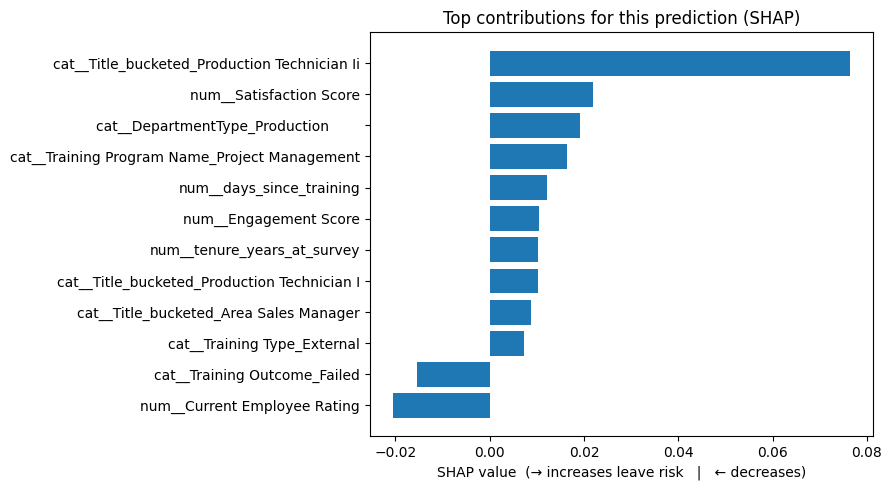

,feature,value,shap
0,cat__Title_bucketed_Production Technician Ii,1.00000,0.076444
1,num__Satisfaction Score,5.00000,0.021942
2,cat__DepartmentType_Production,1.00000,0.019180
3,cat__Training Program Name_Project Management,1.00000,0.016440
4,num__days_since_training,0.00000,0.012218
5,num__Engagement Score,2.00000,0.010506
6,num__tenure_years_at_survey,3.70705,0.010320
7,cat__Title_bucketed_Production Technician I,0.00000,0.010310
8,cat__Title_bucketed_Area Sales Manager,0.00000,0.008813
9,cat__Training Type_External,1.00000,0.007251


,mean_|SHAP|
cat__Title_bucketed_Production Technician Ii,0.016618
cat__DepartmentType_Production,0.015972
cat__Title_bucketed_Area Sales Manager,0.010215
num__tenure_years_at_survey,0.007307
cat__Training Outcome_Completed,0.007244
num__Training Cost,0.007223
num__Current Employee Rating,0.007166
num__days_since_training,0.007007
num__age_years_at_survey,0.004998
num__Satisfaction Score,0.004717


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\859818498.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


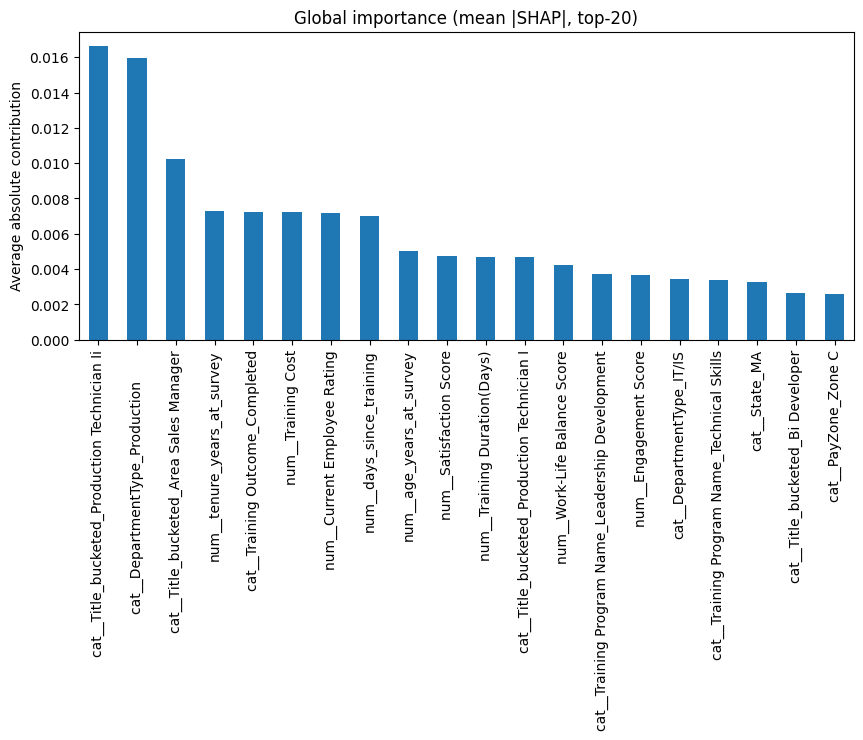

,grouped_mean_|SHAP|
cat__Title_bucketed_Production Technician Ii,0.016618
cat__DepartmentType_Production,0.015972
cat__Title_bucketed_Area Sales Manager,0.010215
num__tenure_years_at_survey,0.007307
cat__Training Outcome_Completed,0.007244
num__Training Cost,0.007223
num__Current Employee Rating,0.007166
num__days_since_training,0.007007
num__age_years_at_survey,0.004998
num__Satisfaction Score,0.004717


In [47]:

#LOCAL explanation (highest-risk)
proba_test = final_rf.predict_proba(X_test)[:, 1]
i = int(np.argmax(proba_test))

row_vals = vals[i].ravel()
row_data = Xt_test[i].ravel()
names    = np.asarray(feat_names).ravel()
assert len(names) == len(row_vals) == len(row_data)

tbl = pd.DataFrame({"feature": names, "shap": row_vals, "value": row_data})
topk = (tbl.reindex(tbl["shap"].abs().sort_values(ascending=False).index)
           .head(12).sort_values("shap"))

plt.figure(figsize=(9,5))
plt.barh(topk["feature"], topk["shap"])
plt.title("Top contributions for this prediction (SHAP)")
plt.xlabel("SHAP value  (→ increases leave risk   |   ← decreases)")
plt.tight_layout(); plt.show()

display(topk[["feature","value","shap"]].iloc[::-1].reset_index(drop=True))


#GLOBAL: mean, SHAP
mean_abs = np.abs(vals).mean(axis=0)
imp = (pd.Series(mean_abs, index=names)
         .sort_values(ascending=False).head(20).to_frame("mean_|SHAP|"))
display(imp)

plt.figure(figsize=(10,4))
imp["mean_|SHAP|"].plot(kind="bar")
plt.title("Global importance (mean |SHAP|, top-20)")
plt.ylabel("Average absolute contribution")
plt.tight_layout(); plt.show()

#GLOBAL grouped (collapse one-hot to raw names)
base_names = [f.split("=")[0] for f in names]
grp_imp = (pd.Series(np.abs(vals).mean(axis=0), index=base_names)
             .groupby(level=0).sum()
             .sort_values(ascending=False).head(15)
             .to_frame("grouped_mean_|SHAP|"))
display(grp_imp)


#### Fairness slice at our chosen threshold t_star

In [48]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate


# Predictions at operating point
y_proba  = final_rf.predict_proba(X_test)[:,1]
y_pred_t = (y_proba >= t_star).astype(int)

audit_cols = [c for c in ["GenderCode","RaceDesc"] if c in df_cln.columns]
X_audit_test = df_cln.loc[X_test.index, audit_cols].fillna("Unknown")

for col in audit_cols:
    mf = MetricFrame(
        metrics={"selection_rate": selection_rate, "tpr": true_positive_rate, "fpr": false_positive_rate},
        y_true=y_test, y_pred=y_pred_t, sensitive_features=X_audit_test[col]
    )
    sr = mf.by_group["selection_rate"]
    di = float(sr.min()/sr.max()) if sr.max() > 0 else np.nan
    print(f"\n{col}: Disparate Impact (min/max selection rate) = {di:.2f}")
    display(mf.by_group)  # shows selection_rate, TPR, FPR by group



GenderCode: Disparate Impact (min/max selection rate) = 0.70


,selection_rate,tpr,fpr
GenderCode,,,
Female,0.194444,0.387755,0.163987
Male,0.136564,0.413793,0.095960



RaceDesc: Disparate Impact (min/max selection rate) = 0.62


,selection_rate,tpr,fpr
RaceDesc,,,
Asian,0.194444,0.357143,0.170213
Black,0.153846,0.285714,0.137931
Hispanic,0.128205,0.307692,0.105769
Other,0.205128,0.500000,0.144330
White,0.182609,0.470588,0.132653


### Dashboard

In [55]:


# 1. SETUP: Select Active Employees
print("Selecting Active Employees...")
# We use df_cln because it has the raw metadata (Department, Title)
active_mask = df_cln["EmployeeStatus"] == "Active"
df_dashboard = df_cln.loc[active_mask].copy()

# 2. FEATURE ENGINEERING (Must match Training Logic exactly)
# A. Date Math
for c in ["StartDate", "DOB", "Survey Date", "Training Date"]:
    df_dashboard[c] = pd.to_datetime(df_dashboard[c], errors="coerce", dayfirst=True)

ref = df_dashboard["Survey Date"]
df_dashboard["tenure_years_at_survey"] = (ref - df_dashboard["StartDate"]).dt.days.div(365.25).clip(lower=0)
df_dashboard["age_years_at_survey"]    = (ref - df_dashboard["DOB"]).dt.days.div(365.25).clip(lower=0)
df_dashboard["days_since_training"]    = (ref - df_dashboard["Training Date"]).dt.days.clip(lower=0)

# B. Title Bucketing (Crucial: The model expects 'Title_bucketed')
# Recalculate Top 20 titles from full dataset to match training
all_titles = df_cln["Title"].astype(str).str.strip().str.lower().replace("", np.nan).fillna("unknown")
top_titles = all_titles.value_counts().head(20).index

df_dashboard["Title_clean"] = df_dashboard["Title"].astype(str).str.strip().str.lower().replace("", np.nan).fillna("unknown")
df_dashboard["Title_bucketed"] = np.where(df_dashboard["Title_clean"].isin(top_titles),
                                          df_dashboard["Title_clean"].str.title(),
                                          "Other")

# 3. PREPARE FEATURE MATRIX
# Drop everything the model doesn't know (Audit cols, IDs, Targets)
drop_cols = [
    "EmployeeStatus", "ExitDate", "TerminationType", "TerminationDescription", "left", 
    "FirstName", "LastName", "ADEmail", "Unnamed: 0", "JobFunctionDescription",       
    "Supervisor", "Trainer", "LocationCode", "Employee ID",                            
    "GenderCode", "RaceDesc", "MaritalDesc",                                           
    "Title", "Title_clean"                                                             
]

X_active = df_dashboard.drop(columns=drop_cols, errors="ignore")
X_active = X_active.select_dtypes(exclude=['datetime64']) 

# 4. PREDICT
print(f"Scoring {len(X_active)} active employees...")
probs = final_rf.predict_proba(X_active)[:, 1]

# 5. CREATE FINAL OUTPUT
df_dashboard["Attrition_Probability"] = probs
# Use the optimized threshold 't_star' (approx 0.203)
df_dashboard["Risk_Label"] = df_dashboard["Attrition_Probability"].apply(
    lambda x: "High Risk" if x >= t_star else "Normal"
)

# 6. ADD EXPLAINABILITY (Based on YOUR SHAP Results)
def get_risk_reason(row):
    reasons = []
    
    # SHAP Finding #1: Production Roles are high risk
    if "Production" in str(row["Title_bucketed"]) or "Production" in str(row["DepartmentType"]):
        reasons.append("High Risk Role (Production)")
        
    # SHAP Finding #2: Tenure 3-5 years is a driver
    if 3 <= row["tenure_years_at_survey"] <= 5:
        reasons.append("Mid-Tenure Risk")
        
    # SHAP Finding #3: Training Failure/Recency
    if row["Training Outcome"] == "Failed":
        reasons.append("Training Failed")
    elif row["days_since_training"] > 365:
        reasons.append("Training Gap (>1yr)")
        
    # SHAP Finding #4: Satisfaction Score
    if row["Satisfaction Score"] <= 2:
        reasons.append("Low Satisfaction")
    
    if not reasons and row["Risk_Label"] == "High Risk":
        return "Complex Risk Pattern"
    return ", ".join(reasons)

df_dashboard["Primary_Risk_Factor"] = df_dashboard.apply(get_risk_reason, axis=1)

# 7. EXPORT
# Join names back if missing
if "FirstName" not in df_dashboard.columns:
    df_raw_names = pd.read_csv('Messy_HR_Dataset_Detailed.csv')
    df_dashboard = df_dashboard.join(df_raw_names[["FirstName", "LastName"]], rsuffix="_raw")

output_cols = [
    "FirstName", "LastName", "Title_bucketed", "DepartmentType",
    "Attrition_Probability", "Risk_Label", "Primary_Risk_Factor", 
    "tenure_years_at_survey", "days_since_training", "Satisfaction Score"
]

# Save to CSV
final_cols = [c for c in output_cols if c in df_dashboard.columns]
df_dashboard[final_cols].to_csv("HR_Attrition_Dashboard_Data.csv", index=False)

print(f"SUCCESS! Dashboard data saved.")
print(f"Threshold Used: {t_star:.3f}")
print(f"High Risk Employees: {len(df_dashboard[df_dashboard['Risk_Label']=='High Risk'])}")
print(df_dashboard[final_cols].head())

Selecting Active Employees...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\2331471838.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_dashboard[c] = pd.to_datetime(df_dashboard[c], errors="coerce", dayfirst=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14356\2331471838.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_dashboard[c] = pd.to_datetime(df_dashboard[c], errors="coerce", dayfirst=True)


Scoring 2458 active employees...
SUCCESS! Dashboard data saved.
Threshold Used: 0.205
High Risk Employees: 67
  FirstName LastName           Title_bucketed     DepartmentType  \
0     Uriah  Bridges  Production Technician I  Production          
1     Paula    Small  Production Technician I  Production          
2    Edward     Buck       Area Sales Manager              Sales   
3   Michael  Riordan       Area Sales Manager              Sales   
4   Jasmine    Onque       Area Sales Manager              Sales   

   Attrition_Probability Risk_Label  \
0                 0.0850     Normal   
1                 0.0900     Normal   
2                 0.0375     Normal   
3                 0.0100     Normal   
4                 0.0250     Normal   

                                 Primary_Risk_Factor  tenure_years_at_survey  \
0  High Risk Role (Production), Mid-Tenure Risk, ...                3.318275   
1      High Risk Role (Production), Low Satisfaction                0.000000   
2  Mid